[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mifumo081a/pytorch_template/blob/main/examples/notebooks/mnist.ipynb)


In [1]:
!git clone https://github.com/mifumo081a/pytorch_template.git
!ls

Cloning into 'pytorch_template'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 109 (delta 36), reused 96 (delta 24), pack-reused 0
Receiving objects: 100% (109/109), 885.39 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (36/36), done.
pytorch_template  sample_data


In [2]:
!pip install -r pytorch_template/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
import os
import torchinfo

In [4]:
root = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN =True

In [5]:
logs_root = os.path.join(root, "logs/", "mnist/")
os.makedirs(logs_root, exist_ok=True)

In [6]:
trainval_dataset = datasets.MNIST(os.path.join(root, "data/"), train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(os.path.join(root, "data/"), train=False, download=True, transform=transforms.ToTensor())

trainval_dataset.labels = [str(i) for i in range(10)]
test_dataset.labels  = [str(i) for i in range(10)]

transforms_dict = {"train": 
                   transforms.Compose([
                       transforms.ToTensor()
                       ]),
                   "val":
                    transforms.Compose([
                       transforms.ToTensor()
                       ]),
                   "test":
                   transforms.Compose([
                       transforms.ToTensor()
                       ])
}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [7]:
import pytorch_template.cross_varidation as cv

In [8]:
num_workers = os.cpu_count()
n_splits = 5
batch_size = 50
if TRAIN:
    kfold_root = cv.kfold_split(dataset=trainval_dataset, test_dataset=test_dataset, transforms=transforms_dict, n_splits=n_splits,
                                root=root, num_workers=num_workers, batch_size=batch_size,
                                shuffle=True, random_state=0)
else:
    os.path.join(root, "kfold_pickle")
print(kfold_root)

Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Train: 48000, Val: 12000
Test: 10000
All: 70000
/content/kfold_pickle


# Model initialize and Train

In [9]:
from pytorch_template.models import *

In [10]:
class Model(GradCAM_Model):
    def __init__(self):
        super().__init__()
        self.features = torchvision.models.vgg16(pretrained=True).features[:10]
        for layer in self.features:
            for param in layer.parameters():
                param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(128, 10),
            nn.Sigmoid(),
        )

    def get_fmaps_alpha(self, x):
        fmaps = self.get_features(x)
        fmaps = fmaps.clone().detach().requires_grad_(True)
        outputs = self.get_outputs(fmaps)
        pred_idx = torch.argmax(outputs)
        outputs[:, pred_idx].backward()
        alpha = fmaps.grad.mean([-2, -1])
        
        return fmaps, alpha

    def get_cam(self, x):
        fmaps, alpha = self.get_fmaps_alpha(x)
        feature_num, cls_num = alpha.shape[1], alpha.shape[0]
        cam_mapper = nn.Conv2d(feature_num, cls_num, kernel_size=1, padding=0, bias=False)
        cam_mapper.weight = nn.Parameter(alpha.unsqueeze(-1).unsqueeze(-1))
        
        with torch.no_grad():
            cam = cam_mapper(fmaps)
            cam = F.relu(cam)
        
        return cam
        
    def get_features(self, x):
        x = x.repeat(1, 3, 1, 1)
        return self.features(x)
    
    def get_outputs(self, x):
        x = x.mean([2, 3])
        return self.classifier(x)
        
    def forward(self,x):
        x = self.get_features(x)
        x = self.get_outputs(x)
        return x

torchinfo.summary(Model(), (1, 1, 28, 28))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           (1,792)
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           (36,928)
│    └─ReLU: 2-4                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-6                       [1, 128, 14, 14]          (73,856)
│    └─ReLU: 2-7                         [1, 128, 14, 14]          --
│    └─Conv2d: 2-8                       [1, 128, 14, 14]          (147,584)
│    └─ReLU: 2-9                         [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-10                   [1, 128, 7, 7]            --
├─Sequential: 1-2                        [1, 10]             

In [11]:
from pytorch_template.utils import get_dataloaders, get_testloaders, get_model, set_model
from pytorch_template.trainer import Trainer_Classifier

In [12]:
model_root = os.path.join(root, "models/")
print(model_root)
if TRAIN:
    set_model(model=Model(), model_root=model_root)

/content/models/


In [15]:
if TRAIN:
  trainer_list = []
  for k in range(n_splits):
    path = os.path.join(kfold_root, str(k)+"/")
    print(path)
    trainer = Trainer_Classifier(model=get_model("nontrain", model_root, device),
                                 device=device, dataloaders=get_dataloaders(path),
                                 epochs=2, lr=1e-3)
    trainer_list.append(trainer)

/content/kfold_pickle/0/
/content/models/nontrain.pkl
/content/kfold_pickle/0/dataloaders.pkl
/content/kfold_pickle/1/
/content/models/nontrain.pkl
/content/kfold_pickle/1/dataloaders.pkl
/content/kfold_pickle/2/
/content/models/nontrain.pkl
/content/kfold_pickle/2/dataloaders.pkl
/content/kfold_pickle/3/
/content/models/nontrain.pkl
/content/kfold_pickle/3/dataloaders.pkl
/content/kfold_pickle/4/
/content/models/nontrain.pkl
/content/kfold_pickle/4/dataloaders.pkl


In [16]:
if TRAIN:
    cv.kfold_train(save_model_root=model_root, n_splits=n_splits,
                   trainer_list=trainer_list)

Pattern:  0


[Epoch2/2]: 100%|██████████| 2/2 [00:18<00:00,  9.09s/it, Loss=1.77, Acc=0.853]


Best val Loss: 1.7709
Acc: 0.8532 
Pattern:  1


[Epoch2/2]: 100%|██████████| 2/2 [00:18<00:00,  9.05s/it, Loss=1.78, Acc=0.817]


Best val Loss: 1.7782
Acc: 0.8174 
Pattern:  2


[Epoch2/2]: 100%|██████████| 2/2 [00:18<00:00,  9.07s/it, Loss=1.77, Acc=0.856]


Best val Loss: 1.7733
Acc: 0.8561 
Pattern:  3


[Epoch2/2]: 100%|██████████| 2/2 [00:18<00:00,  9.31s/it, Loss=1.77, Acc=0.857]


Best val Loss: 1.7731
Acc: 0.8568 
Pattern:  4


[Epoch2/2]: 100%|██████████| 2/2 [00:18<00:00,  9.04s/it, Loss=1.77, Acc=0.824]

Best val Loss: 1.7731
Acc: 0.8241 


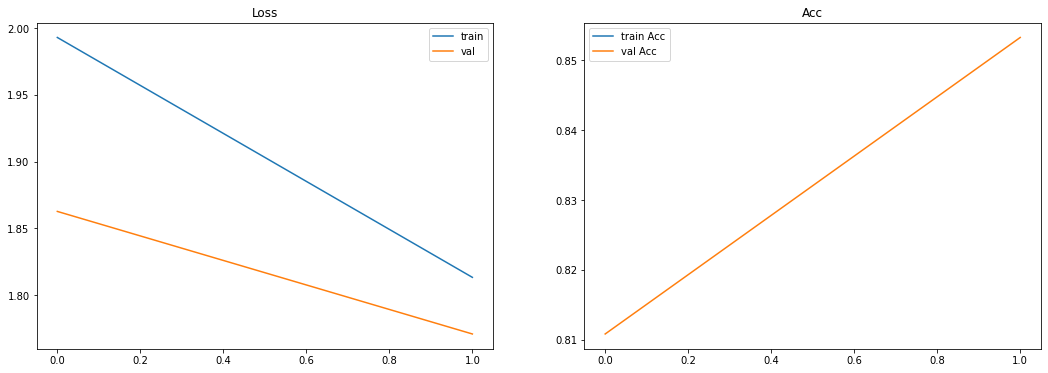

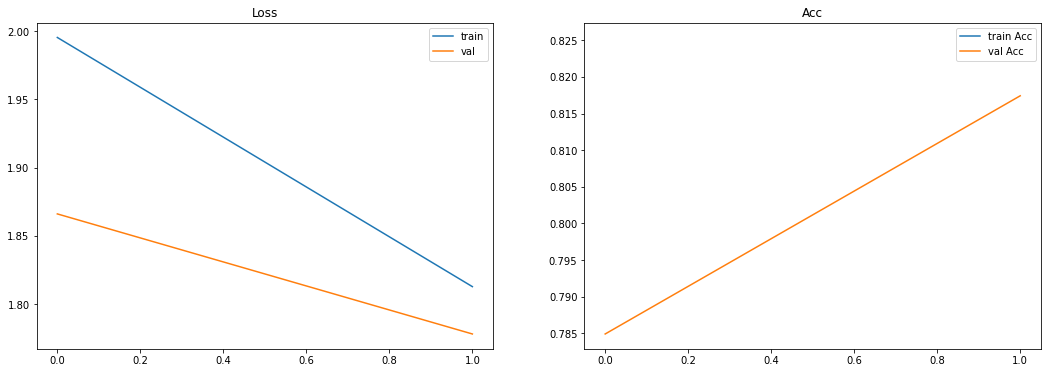

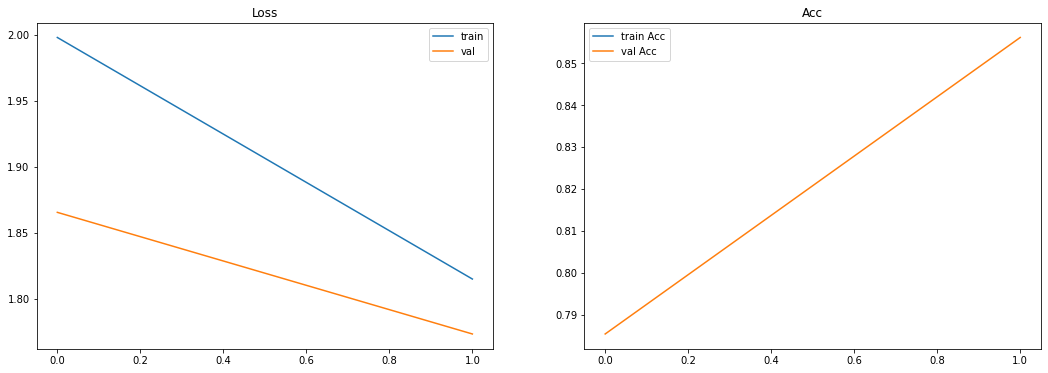

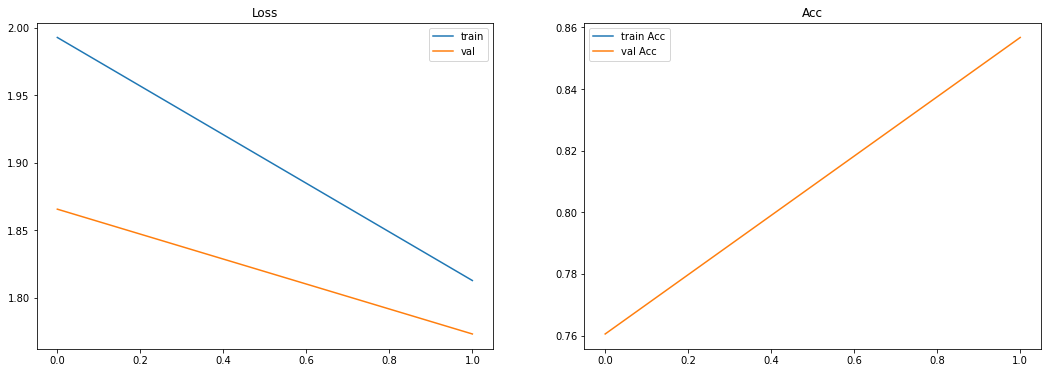

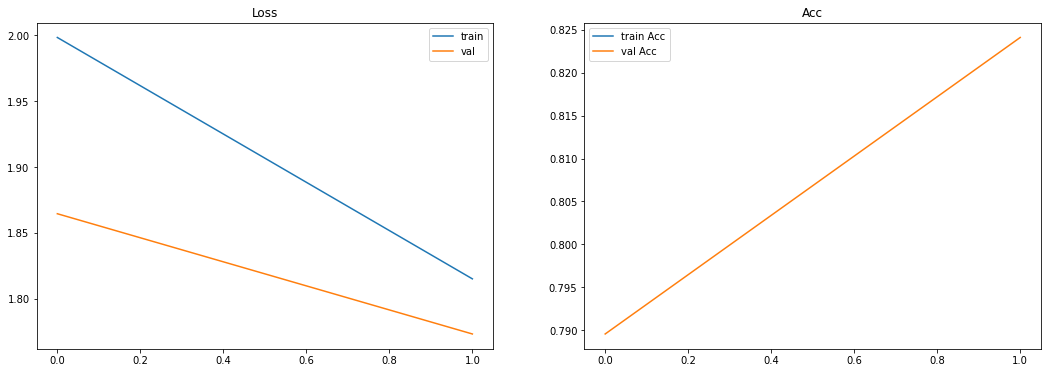

In [17]:
if TRAIN:
    for k in range(n_splits):
        path = os.path.join(kfold_root, str(k)+"/")
        trainer_list[k].show_curve(logs_root=os.path.join
                                   (logs_root, "curves/"), fname=str(k), save=False)

# Evaluate models

In [18]:
from pytorch_template.evaluator import ImageClassifier_Evaluator

In [19]:
evaluator_list = []
for k in range(n_splits):
    dataloader_path = os.path.join(kfold_root, str(k)+"/")
    model_path = os.path.join(model_root, str(k)+"/")
    print(dataloader_path, model_path)
    evaluator_list.append(ImageClassifier_Evaluator(model=get_model("model_fit", model_path, device),
                                          device=device,
                                          dataloaders=get_dataloaders(dataloader_path),
                                          testloaders=get_testloaders(kfold_root),
                                          logs_root=logs_root
                                         )
                         )

/content/kfold_pickle/0/ /content/models/0/
/content/models/0/model_fit.pkl
/content/kfold_pickle/0/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/1/ /content/models/1/
/content/models/1/model_fit.pkl
/content/kfold_pickle/1/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/2/ /content/models/2/
/content/models/2/model_fit.pkl
/content/kfold_pickle/2/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/3/ /content/models/3/
/content/models/3/model_fit.pkl
/content/kfold_pickle/3/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl
/content/kfold_pickle/4/ /content/models/4/
/content/models/4/model_fit.pkl
/content/kfold_pickle/4/dataloaders.pkl
/content/kfold_pickle/testloaders.pkl


              precision    recall  f1-score   support

           0       0.87      0.91      0.89       980
           1       0.97      0.99      0.98      1135
           2       0.66      0.85      0.74      1032
           3       0.93      0.77      0.84      1010
           4       0.90      0.89      0.89       982
           5       0.75      0.77      0.76       892
           6       0.88      0.86      0.87       958
           7       0.92      0.83      0.87      1028
           8       0.94      0.86      0.90       974
           9       0.86      0.85      0.85      1009

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



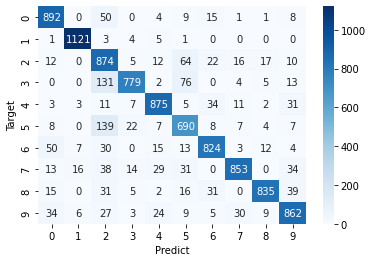

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       980
           1       0.98      0.99      0.98      1135
           2       0.65      0.82      0.72      1032
           3       0.98      0.55      0.71      1010
           4       0.92      0.89      0.90       982
           5       0.62      0.88      0.73       892
           6       0.93      0.81      0.87       958
           7       0.95      0.80      0.87      1028
           8       0.92      0.85      0.89       974
           9       0.75      0.91      0.82      1009

    accuracy                           0.84     10000
   macro avg       0.86      0.84      0.84     10000
weighted avg       0.87      0.84      0.84     10000



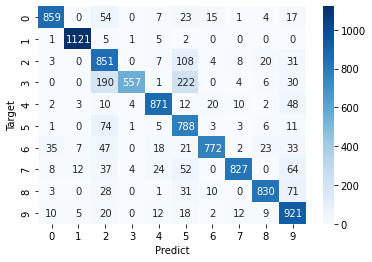

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       980
           1       0.98      0.99      0.98      1135
           2       0.66      0.84      0.74      1032
           3       0.88      0.87      0.88      1010
           4       0.87      0.91      0.89       982
           5       0.83      0.72      0.77       892
           6       0.92      0.84      0.88       958
           7       0.88      0.86      0.87      1028
           8       0.90      0.89      0.89       974
           9       0.87      0.84      0.85      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.86      0.87     10000
weighted avg       0.87      0.87      0.87     10000



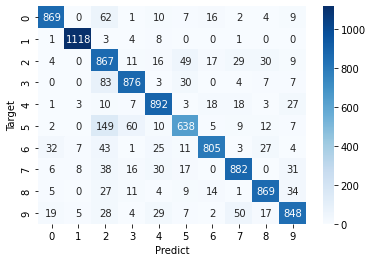

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       980
           1       0.98      0.98      0.98      1135
           2       0.79      0.75      0.77      1032
           3       0.90      0.84      0.87      1010
           4       0.91      0.88      0.90       982
           5       0.67      0.88      0.76       892
           6       0.88      0.87      0.88       958
           7       0.88      0.86      0.87      1028
           8       0.96      0.82      0.89       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.87      0.87     10000



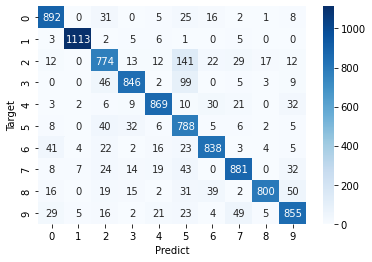

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       980
           1       0.98      0.98      0.98      1135
           2       0.54      0.88      0.67      1032
           3       0.97      0.52      0.68      1010
           4       0.92      0.87      0.89       982
           5       0.74      0.75      0.74       892
           6       0.87      0.86      0.87       958
           7       0.87      0.85      0.86      1028
           8       0.87      0.91      0.89       974
           9       0.91      0.79      0.85      1009

    accuracy                           0.83     10000
   macro avg       0.86      0.83      0.83     10000
weighted avg       0.86      0.83      0.84     10000



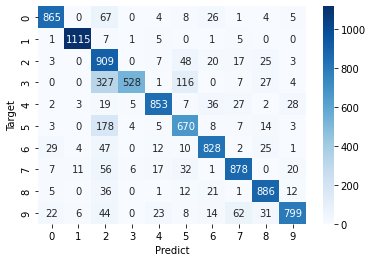

In [20]:
kfold_acc = []
for k in range(n_splits):
    evaluator_list[k].confusion_matrix(folder_name="confusion_matrix", fname=str(k), save=False)
    kfold_acc.append(evaluator_list[k].acc)

In [21]:
print("Acc mean: {:.4f}, std: {:.4f}".format(np.array(kfold_acc).mean(), np.array(kfold_acc).std()))

Acc mean: 0.8531, std: 0.0139


In [22]:
for k in range(n_splits):
    evaluator_list[k].show_scores(folder_name="eval", fname=str(k), save=False)

Accuracy: 0.8605
F scores: (0: 0.8884)(1: 0.9799)(2: 0.7388)(3: 0.8426)(4: 0.8942)(5: 0.7641)(6: 0.8687)(7: 0.8735)(8: 0.8983)(9: 0.8547)
Recalls: (0: 0.9102)(1: 0.9877)(2: 0.8469)(3: 0.7713)(4: 0.8910)(5: 0.7735)(6: 0.8601)(7: 0.8298)(8: 0.8573)(9: 0.8543)
Precisions: (0: 0.8677)(1: 0.9722)(2: 0.6552)(3: 0.9285)(4: 0.8974)(5: 0.7549)(6: 0.8775)(7: 0.9222)(8: 0.9435)(9: 0.8552)
Accuracy: 0.8397
F scores: (0: 0.9033)(1: 0.9820)(2: 0.7249)(3: 0.7064)(4: 0.9012)(5: 0.7266)(6: 0.8655)(7: 0.8728)(8: 0.8858)(9: 0.8242)
Recalls: (0: 0.8765)(1: 0.9877)(2: 0.8246)(3: 0.5515)(4: 0.8870)(5: 0.8834)(6: 0.8058)(7: 0.8045)(8: 0.8522)(9: 0.9128)
Precisions: (0: 0.9317)(1: 0.9765)(2: 0.6467)(3: 0.9824)(4: 0.9159)(5: 0.6171)(6: 0.9346)(7: 0.9539)(8: 0.9222)(9: 0.7512)
Accuracy: 0.8664
F scores: (0: 0.9057)(1: 0.9824)(2: 0.7404)(3: 0.8756)(4: 0.8880)(5: 0.7673)(6: 0.8774)(7: 0.8703)(8: 0.8945)(9: 0.8544)
Recalls: (0: 0.8867)(1: 0.9850)(2: 0.8401)(3: 0.8673)(4: 0.9084)(5: 0.7152)(6: 0.8403)(7: 0.8580)(8:

Classified as  5 , model output = tensor([0.0365, 0.0015, 0.7046, 0.6929, 0.0234, 0.8131, 0.1302, 0.0763, 0.0796,
        0.0561], device='cuda:0')
5 ( 5 ) 16.46 %
2 ( 2 ) 14.77 %
3 ( 3 ) 14.60 %
6 ( 6 ) 8.32 %
8 ( 8 ) 7.90 %
7 ( 7 ) 7.88 %
9 ( 9 ) 7.72 %
0 ( 0 ) 7.57 %
4 ( 4 ) 7.47 %
1 ( 1 ) 7.31 %


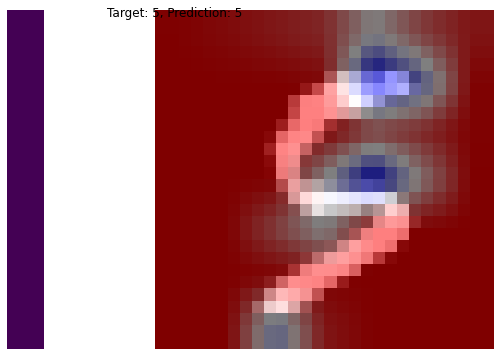

Classified as  1 , model output = tensor([0.0196, 0.9969, 0.0034, 0.0028, 0.6943, 0.0075, 0.1781, 0.7883, 0.0045,
        0.3097], device='cuda:0')
1 ( 1 ) 18.68 %
7 ( 7 ) 15.16 %
4 ( 4 ) 13.80 %
9 ( 9 ) 9.40 %
6 ( 6 ) 8.24 %
0 ( 0 ) 7.03 %
5 ( 5 ) 6.94 %
8 ( 8 ) 6.92 %
2 ( 2 ) 6.92 %
3 ( 3 ) 6.91 %


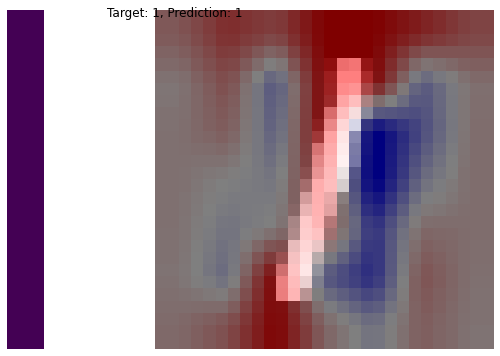

Classified as  0 , model output = tensor([0.5795, 0.0074, 0.0828, 0.0445, 0.0468, 0.0616, 0.3868, 0.0169, 0.5317,
        0.2685], device='cuda:0')
0 ( 0 ) 14.24 %
8 ( 8 ) 13.58 %
6 ( 6 ) 11.75 %
9 ( 9 ) 10.43 %
2 ( 2 ) 8.67 %
5 ( 5 ) 8.48 %
4 ( 4 ) 8.36 %
3 ( 3 ) 8.34 %
7 ( 7 ) 8.11 %
1 ( 1 ) 8.04 %


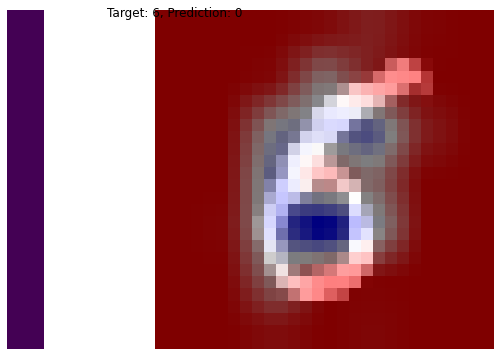

Classified as  7 , model output = tensor([0.0190, 0.0786, 0.0115, 0.0303, 0.1758, 0.0199, 0.3199, 0.8056, 0.0784,
        0.7510], device='cuda:0')
7 ( 7 ) 16.99 %
9 ( 9 ) 16.09 %
6 ( 6 ) 10.45 %
4 ( 4 ) 9.05 %
1 ( 1 ) 8.21 %
8 ( 8 ) 8.21 %
3 ( 3 ) 7.83 %
5 ( 5 ) 7.74 %
0 ( 0 ) 7.74 %
2 ( 2 ) 7.68 %


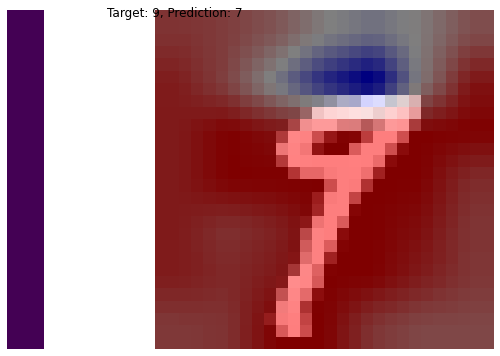

Classified as  3 , model output = tensor([0.0630, 0.0009, 0.6363, 0.7752, 0.0225, 0.5133, 0.0345, 0.2130, 0.0805,
        0.0798], device='cuda:0')
3 ( 3 ) 16.37 %
2 ( 2 ) 14.25 %
5 ( 5 ) 12.60 %
7 ( 7 ) 9.33 %
8 ( 8 ) 8.17 %
9 ( 9 ) 8.17 %
0 ( 0 ) 8.03 %
6 ( 6 ) 7.81 %
4 ( 4 ) 7.71 %
1 ( 1 ) 7.55 %


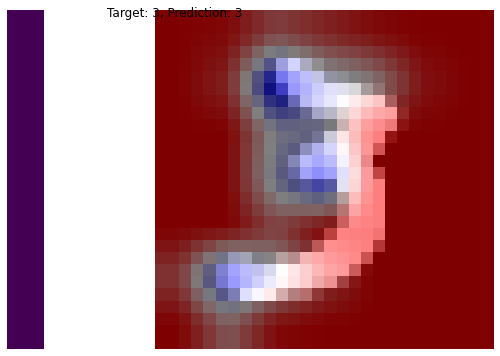

In [23]:
for k in range(n_splits):
    evaluator_list[k].show_cam(folder_name="cam", fname=str(k), save=False)